# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np


import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [5]:
train = pd.read_parquet('./dataset/train_temp.parquet.gzip') 
test = pd.read_parquet('./dataset/test_temp.parquet.gzip') 

In [6]:
VARS = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'QGL']

In [7]:
train.head()

P-PDG       P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  QGL  \
7365884    0.0  18433410.0  116.8718  9397031.0   74.80031   -300917.8  0.0   
7365885    0.0  18433410.0  116.8718  9397031.0   74.80031   -300917.8  0.0   
7365886    0.0  18433410.0  116.8718  9397032.0   74.80031   -300917.8  0.0   
7365887    0.0  18433410.0  116.8718  9397033.0   74.80031   -300917.8  0.0   
7365888    0.0  18433410.0  116.8718  9397033.0   74.80031   -300917.8  0.0   

                  timestamp        well  target  
7365884 2014-01-24 09:33:03  WELL-00001       1  
7365885 2014-01-24 09:33:04  WELL-00001       1  
7365886 2014-01-24 09:33:05  WELL-00001       1  
7365887 2014-01-24 09:33:06  WELL-00001       1  
7365888 2014-01-24 09:33:07  WELL-00001       1

## Isolation Forest

In [185]:
with open('./models/pipeline_iForest.pkl', 'rb') as f:
    iforest = pickle.load(f) 

In [186]:
iforest

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 IsolationForest(contamination=0.01, max_features=0.7,
                                 n_estimators=256, random_state=42))])

In [10]:
y_pred = iforest.predict(test[VARS])
test['iForest'] = np.where(y_pred == -1, 1, 0)  

In [11]:
y_pred = iforest.predict(train[VARS])
train['iForest'] = np.where(y_pred == -1, 1, 0)  

In [12]:
test['scores_forest']=-iforest.decision_function(test[VARS])

In [13]:
# train['scores_forest'] = -iforest.score_samples(train[VARS])

train['scores_forest'] = -iforest.decision_function(train[VARS])

In [14]:
test['iForest'].value_counts()

iForest
0    1682648
1     539152
Name: count, dtype: int64

<Axes: xlabel='scores_forest', ylabel='Density'>

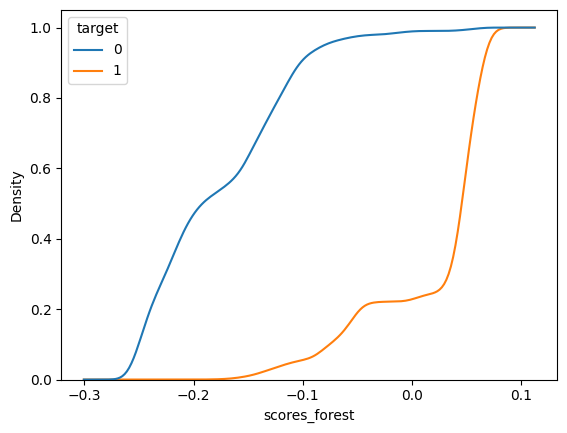

In [15]:
sns.kdeplot(
    data=train.sample(frac=0.01), x="scores_forest", hue=train.target,
    cumulative=True, common_norm=False, common_grid=True,
)

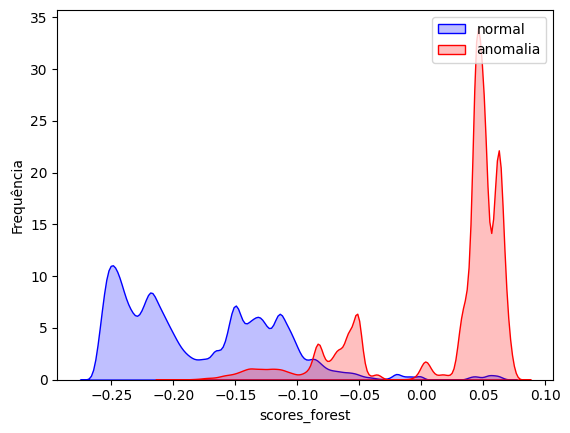

In [16]:
g = sns.kdeplot(train["scores_forest"][(train["target"] == 0) & (train["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(train["scores_forest"][(train["target"] == 1) & (train["scores_forest"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

<Axes: xlabel='scores_forest', ylabel='Density'>

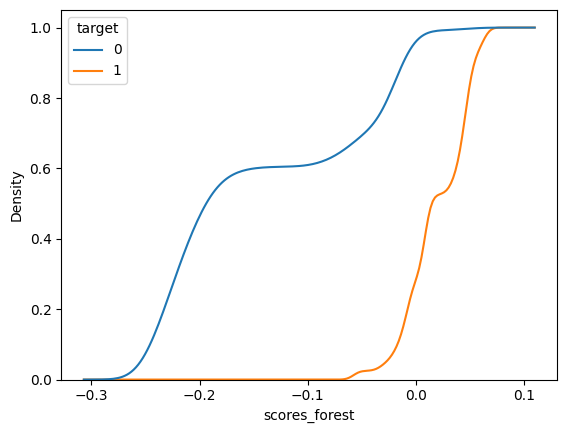

In [17]:
sns.kdeplot(
    data=test.sample(frac=0.01), x="scores_forest", hue=test.target,
    cumulative=True, common_norm=False, common_grid=True,
)

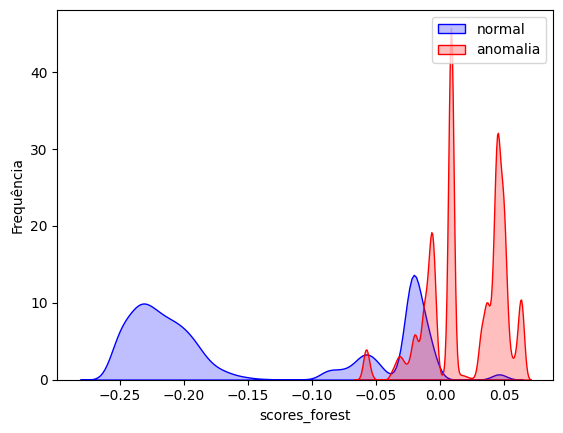

In [18]:
g = sns.kdeplot(test["scores_forest"][(test["target"] == 0) & (test["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_forest"][(test["target"] == 1) & (test["scores_forest"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

### Metrics

Classification Report: 
               precision    recall  f1-score   support

           0    0.89587   0.99000   0.94059   5872276
           1    0.97552   0.77587   0.86432   3014901

    accuracy                        0.91736   8887177
   macro avg    0.93569   0.88294   0.90245   8887177
weighted avg    0.92289   0.91736   0.91471   8887177

Specificity: 0.99000268379756
Gini:  0.7658765847979576
ROC AUC::  0.8829382923989788


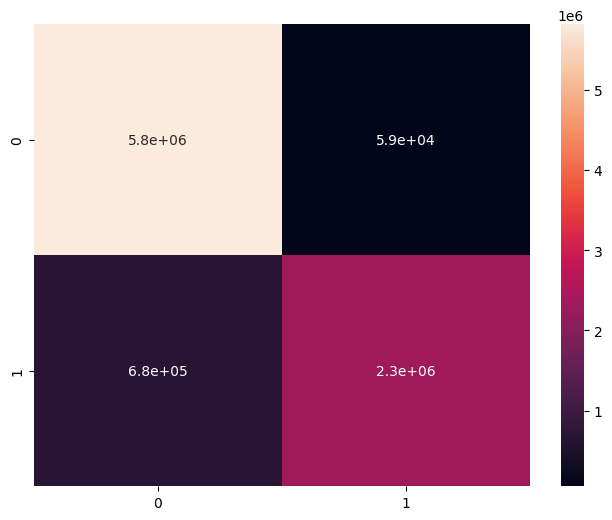

In [19]:
metrics(train.target, train.iForest)

Classification Report: 
               precision    recall  f1-score   support

           0    0.87907   0.99033   0.93138   1493608
           1    0.97320   0.72055   0.82803    728192

    accuracy                        0.90191   2221800
   macro avg    0.92613   0.85544   0.87971   2221800
weighted avg    0.90992   0.90191   0.89751   2221800

Specificity: 0.9903254401422595
Gini:  0.7108799092932527
ROC AUC::  0.8554399546466264


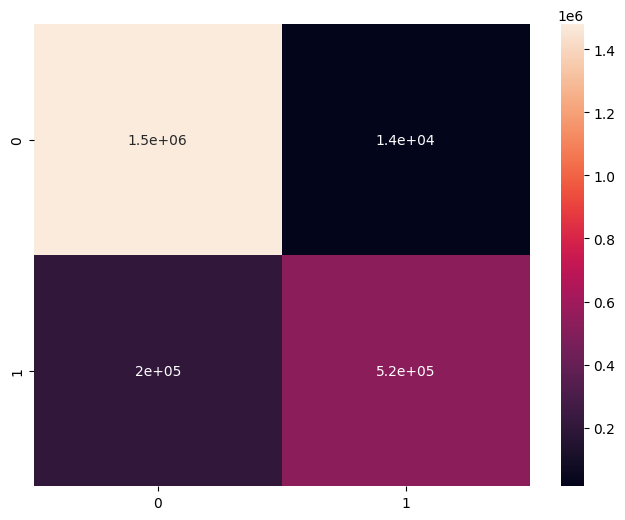

In [20]:
metrics(test.target, test.iForest)

## LODA

In [22]:
## Isolation Forest
with open('./models/pipeline_LODA.pkl', 'rb') as f:
    loda = pickle.load(f) 
loda

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 LODA(contamination=0.001, n_bins=2000, n_random_cuts=500))])

In [23]:
test['loda'] = loda.predict(test[VARS])

train['loda'] = loda.predict(train[VARS])

test['loda'].value_counts()

loda
0    1467669
1     754131
Name: count, dtype: int64

In [24]:
test['scores_loda']= loda.decision_function(test[VARS])

train['scores_loda'] = loda.decision_function(train[VARS])

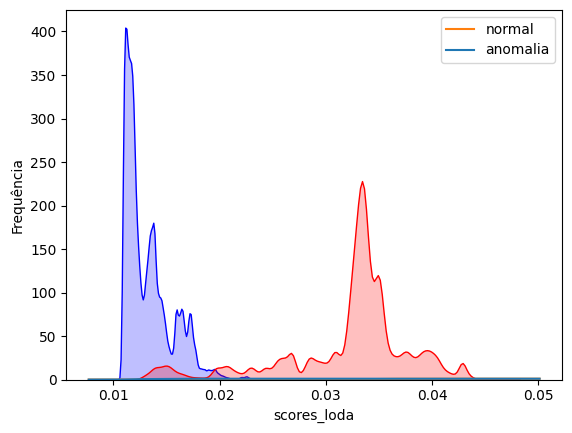

In [25]:
sns.kdeplot(
    data=train.sample(frac=0.01), x="scores_loda", hue=train.target,
    cumulative=True, common_norm=False, common_grid=True,
)
g = sns.kdeplot(train["scores_loda"][(train["target"] == 0) & (train["scores_loda"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(train["scores_loda"][(train["target"] == 1) & (train["scores_loda"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_loda")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

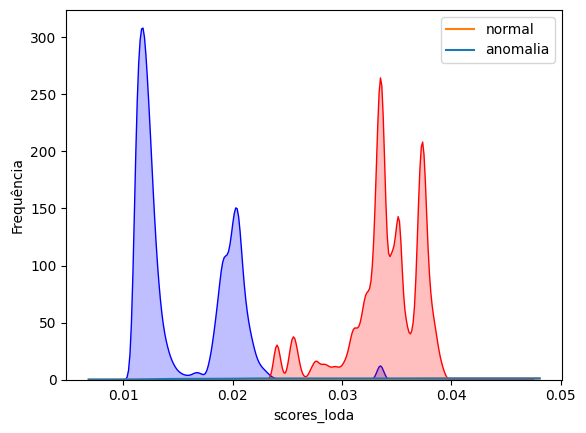

In [26]:
sns.kdeplot(
    data=test.sample(frac=0.01), x="scores_loda", hue=test.target,
    cumulative=True, common_norm=False, common_grid=True,
)
g = sns.kdeplot(test["scores_loda"][(test["target"] == 0) & (test["scores_loda"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(test["scores_loda"][(test["target"] == 1) & (test["scores_loda"].notnull())], ax =g, color="Red", fill= True)

g.set_xlabel("scores_loda")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomalia'])

Classification Report: 
               precision    recall  f1-score   support

           0    0.95467   0.99900   0.97633   5872276
           1    0.99786   0.90760   0.95059   3014901

    accuracy                        0.96799   8887177
   macro avg    0.97626   0.95330   0.96346   8887177
weighted avg    0.96932   0.96799   0.96760   8887177

Specificity: 0.9989998767087923
Gini:  0.9066038079821575
ROC AUC::  0.9533019039910787


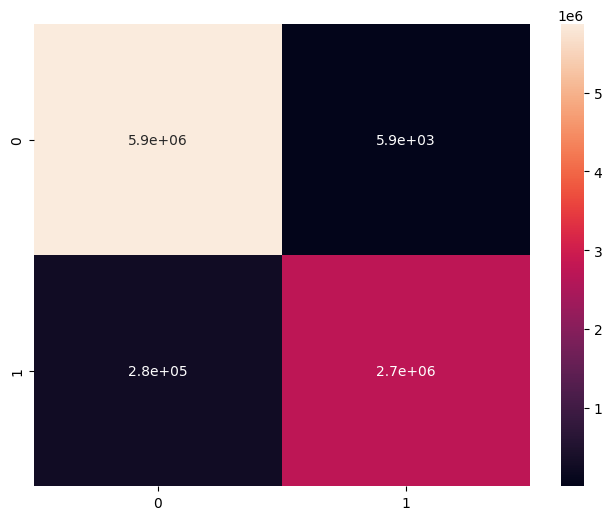

In [27]:
metrics(train.target, train.loda)

Classification Report: 
               precision    recall  f1-score   support

           0    1.00000   0.98263   0.99124   1493608
           1    0.96560   1.00000   0.98250    728192

    accuracy                        0.98833   2221800
   macro avg    0.98280   0.99132   0.98687   2221800
weighted avg    0.98873   0.98833   0.98838   2221800

Specificity: 0.9826333281557142
Gini:  0.9826333281557142
ROC AUC::  0.9913166640778571


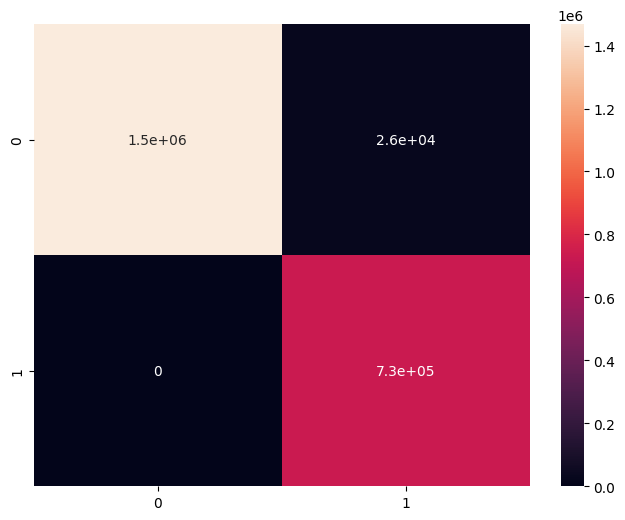

In [28]:
metrics(test.target, test.loda)

## Chart Control

In [21]:
train.groupby("well")["target"].sum()

well
WELL-00001    410321
WELL-00002    878303
WELL-00006    175174
WELL-00007     68816
WELL-00009      5358
WELL-00010    481363
WELL-00014    559787
WELL-00015     43848
WELL-00016     16372
WELL-00017    305830
WELL-00018     69729
Name: target, dtype: int64

In [22]:
train.groupby("well")["target"].count()

well
WELL-00001    1650210
WELL-00002    3615177
WELL-00006    2070687
WELL-00007      68816
WELL-00009       5358
WELL-00010     481363
WELL-00014     559787
WELL-00015      43848
WELL-00016      16372
WELL-00017     305830
WELL-00018      69729
Name: target, dtype: int64

In [23]:
test.groupby("well")["target"].sum()

well
WELL-00001         0
WELL-00002         0
WELL-00006    354782
WELL-00007      2835
WELL-00009      1340
WELL-00010    120341
WELL-00014    139947
WELL-00015     10963
WELL-00016      4093
WELL-00017     76458
WELL-00018     17433
Name: target, dtype: int64

In [24]:
test.groupby("well")["target"].count()

well
WELL-00001    412553
WELL-00002    903795
WELL-00006    517672
WELL-00007     17205
WELL-00009      1340
WELL-00010    120341
WELL-00014    139947
WELL-00015     10963
WELL-00016      4093
WELL-00017     76458
WELL-00018     17433
Name: target, dtype: int64

In [25]:
train_sample_ewma_under_control = train[(train['target'] == 0)].reset_index(drop=True)
scores_train_under_control = train_sample_ewma_under_control['scores_forest'].values
# scores_train_under_control = train_sample_ewma_under_control['scores_loda'].values
sigma = np.std(scores_train_under_control)
mu = np.mean(scores_train_under_control)


train_sample_ewma_out_of_control = train[(train['target'] == 1)].reset_index(drop=True)
scores_train_out_of_control = train_sample_ewma_out_of_control['scores_forest'].values
# scores_train_out_of_control = train_sample_ewma_out_of_control['scores_loda'].values
anomaly_mu = np.mean(scores_train_out_of_control)

In [26]:
sigma

0.0625590162671142

In [27]:
mu

-0.17816135155787402

In [28]:
anomaly_mu

0.0206680663041816

In [29]:
# Função para calcular EWMA
def calculate_ewma(scores, lambda_):
    Z = np.zeros_like(scores)
    Z[0] = scores[0]
    for t in range(1, len(scores)):
        Z[t] = lambda_ * scores[t] + (1 - lambda_) * Z[t - 1]
    return Z

# Função para calcular limites de controle
def calculate_control_limits(mu, sigma, lambda_, L):
    std_dev = sigma * np.sqrt(lambda_ / (2 - lambda_))
    UCL = mu + L * std_dev
    LCL = mu - L * std_dev
    return UCL, LCL

# Função para plotar carta de controle
def plot_control_chart(scores, ewma, UCL, LCL, lambda_, L):
    plt.figure(figsize=(12, 6))
    # plt.plot(scores, label='Scores', color='blue', alpha=0.5)
    plt.plot(ewma, label='EWMA', color='blue')
    plt.axhline(y=mu, color='green', linestyle='--', label='Mean')
    plt.axhline(y=UCL, color='red', linestyle='--', label='UCL')
    plt.axhline(y=LCL, color='red', linestyle='--', label='LCL')
    plt.title(f'EWMA Control Chart (λ={lambda_}, L={L})')
    plt.xlabel('Time')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [30]:
# Simulação de Monte Carlo com técnica de deslizamento
def monte_carlo_simulation(scores, lambda_, L, mu, sigma, window_size, num_simulations=1000):
    run_lengths = []
    n = len(scores)
    for _ in range(num_simulations):

        start_idx = np.random.randint(0, n - window_size)
        sample_scores = scores[start_idx:start_idx + window_size]
    
        ewma = calculate_ewma(sample_scores, lambda_)
        UCL, LCL = calculate_control_limits(mu, sigma, lambda_, L)
        # out_of_control = np.where((ewma > UCL) | (ewma < LCL))[0]
        out_of_control = np.where((ewma > UCL))[0]
        if len(out_of_control) == 0:
            run_lengths.append(window_size)  # No points out of control
        else:
            run_lengths.append(out_of_control[0] + 1)
    ARL = np.mean(run_lengths)
    MRL = np.median(run_lengths)
    SRL = np.std(run_lengths)
    return ARL, MRL, SRL

# Parâmetros para análise de sensibilidade
lambdas = [0.1, 0.2, 0.3, 0.4, 0.5]
Ls = [2, 2.5, 3]
window_size = 500  # Tamanho da janela deslizante

# Resultados da análise de sensibilidade
results_in_control = []
results_out_of_control = []

for lambda_ in lambdas:
    for L in Ls:
        ARL_in, MRL_in, SRL_in = monte_carlo_simulation(scores_train_under_control, lambda_, L, mu, sigma, window_size)
        ARL_out, MRL_out, SRL_out = monte_carlo_simulation(scores_train_out_of_control, lambda_, L, mu, sigma, window_size)
        results_in_control.append([lambda_, L, ARL_in, MRL_in, SRL_in])
        results_out_of_control.append([lambda_, L, ARL_out, MRL_out, SRL_out])

# Guardar resultados numa tabela
results_df_in_control = pd.DataFrame(results_in_control, columns=['Lambda', 'L', 'ARL_in', 'MRL_in', 'SRL_in'])
results_df_out_of_control = pd.DataFrame(results_out_of_control, columns=['Lambda', 'L', 'ARL_out', 'MRL_out', 'SRL_out'])

In [31]:
results_df_in_control

Lambda    L   ARL_in  MRL_in      SRL_in
0      0.1  2.0  300.268   500.0  240.054553
1      0.1  2.5  328.764   500.0  232.300530
2      0.1  3.0  338.113   500.0  230.006657
3      0.2  2.0  340.024   500.0  229.075563
4      0.2  2.5  372.490   500.0  213.396565
5      0.2  3.0  406.864   500.0  188.901899
6      0.3  2.0  363.658   500.0  217.801173
7      0.3  2.5  402.896   500.0  191.688255
8      0.3  3.0  443.560   500.0  152.569428
9      0.4  2.0  389.379   500.0  201.457686
10     0.4  2.5  440.220   500.0  156.958955
11     0.4  3.0  463.379   500.0  127.316430
12     0.5  2.0  422.399   500.0  172.726448
13     0.5  2.5  463.899   500.0  126.200669
14     0.5  3.0  472.011   500.0  112.731535

In [32]:
results_df_out_of_control

Lambda    L  ARL_out  MRL_out     SRL_out
0      0.1  2.0    4.122      1.0   33.141622
1      0.1  2.5    6.046      1.0   46.590448
2      0.1  3.0    4.212      1.0   37.109285
3      0.2  2.0    7.110      1.0   48.483130
4      0.2  2.5   16.815      1.0   84.724901
5      0.2  3.0   20.768      1.0   92.658104
6      0.3  2.0   10.822      1.0   67.217753
7      0.3  2.5   16.233      1.0   81.705500
8      0.3  3.0   29.293      1.0  114.449837
9      0.4  2.0   19.125      1.0   90.091117
10     0.4  2.5   32.591      1.0  121.008784
11     0.4  3.0   31.193      1.0  117.051031
12     0.5  2.0   24.530      1.0  103.736508
13     0.5  2.5   31.562      1.0  118.930291
14     0.5  3.0   51.600      1.0  150.036882

Melhor cenário: λ=0.5, L=2.5, ARL_in=463.899, ARL_out=31.562


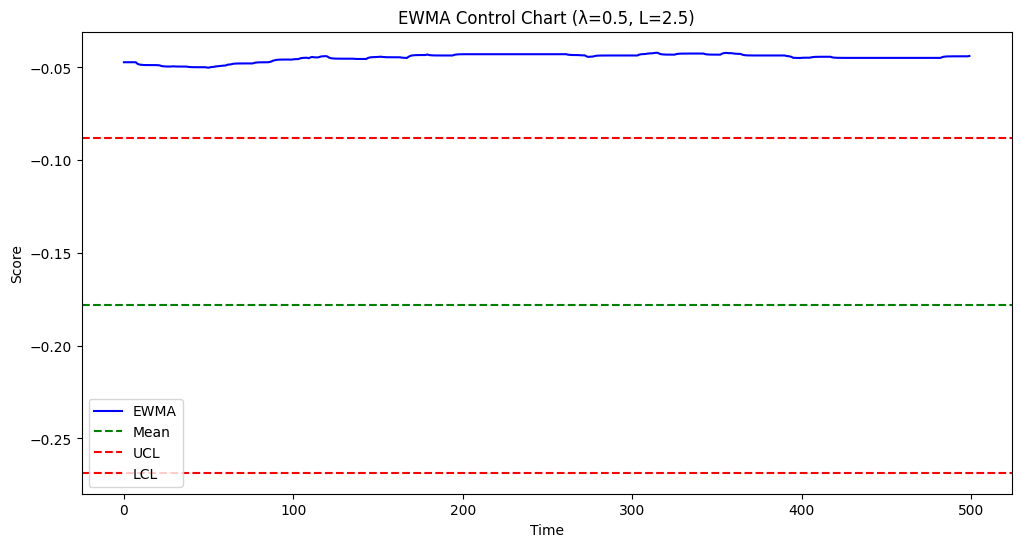

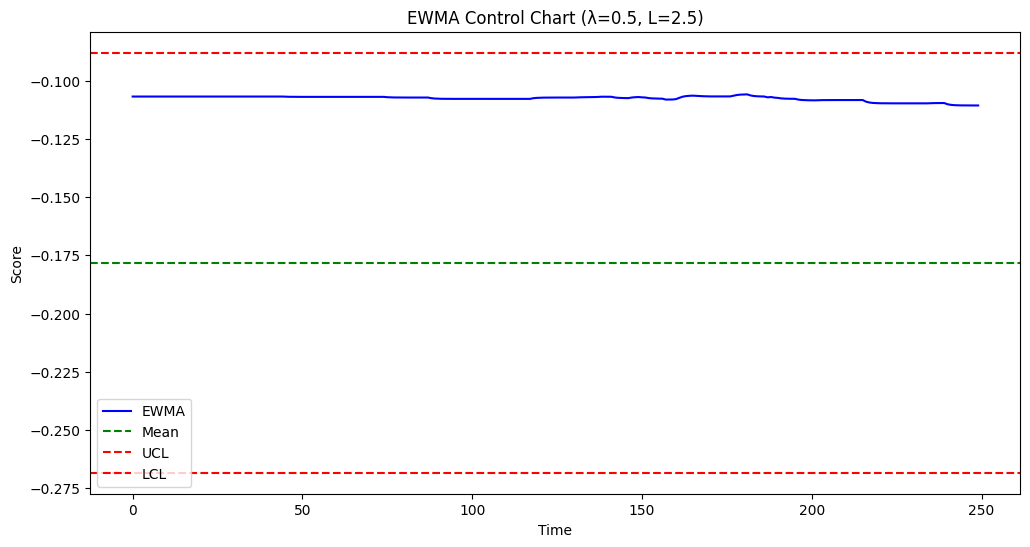

In [33]:
# Determinar o melhor cenário (maximizar ARL_in e minimizar ARL_out)
best_scenario = None
best_score = -np.inf

for i in range(len(results_df_in_control)):
    lambda_ = results_df_in_control.iloc[i]['Lambda']
    L = results_df_in_control.iloc[i]['L']
    ARL_in = results_df_in_control.iloc[i]['ARL_in']
    ARL_out = results_df_out_of_control.iloc[i]['ARL_out']
    
    # Score para determinar o melhor cenário (ajustável conforme a necessidade)
    score = ARL_in - ARL_out
    
    if score > best_score:
        best_score = score
        best_scenario = (lambda_, L, ARL_in, ARL_out)

lambda_, L, ARL_in, ARL_out = best_scenario
print(f"Melhor cenário: λ={lambda_}, L={L}, ARL_in={ARL_in}, ARL_out={ARL_out}")

# Gerar dados para o melhor cenário
n = len(scores_train_under_control)
start_idx = np.random.randint(0, n - window_size)
scores_in_control = scores_train_under_control[start_idx:start_idx + window_size]
ewma_in_control = calculate_ewma(scores_in_control, lambda_)
UCL, LCL = calculate_control_limits(mu, sigma, lambda_, L)

# Plotar carta de controle para dados sob controle no melhor cenário
plot_control_chart(scores_in_control, ewma_in_control, UCL, LCL, lambda_, L)


# Gerar dados fora de controle para o melhor cenário
n = len(scores_train_out_of_control)
start_idx = np.random.randint(0, n//2 - window_size//2)
scores_out_of_control = scores_train_out_of_control[start_idx:start_idx + window_size//2]
ewma_out_of_control = calculate_ewma(scores_out_of_control, lambda_)

# Plotar carta de controle para dados fora de controle no melhor cenário
plot_control_chart(scores_out_of_control, ewma_out_of_control, UCL, LCL, lambda_, L)

In [34]:
train.shape

(8887177, 12)

In [35]:
test.shape

(2221800, 12)

In [36]:
# test_sample_ewma = test[test['well']=='WELL-00006']
# test_sample_ewma = test_sample_ewma.reset_index(drop=True)

# test_sample_ewma = pd.concat([train[train['well']=='WELL-00002'], test[test['well']=='WELL-00002']], axis=0)
# test_sample_ewma = test_sample_ewma.reset_index(drop=True)
# test_sample_ewma.shape

# split_index = int(0.5* len(spc_sample_test))
# test_sample_ewma = spc_sample_test.iloc[:split_index].reset_index(drop=True)
# test_sample_ewma.shape

In [47]:
# test_sample_ewma.head()

In [155]:
# Função para plotar carta de controle
def plot_control_chart_anomaly_detection(test_sample_ewma, test_scores, ewma, UCL, LCL, lambda_, L):
    plt.figure(figsize=(15, 6))
    anomaous_target = test_sample_ewma.target.tolist()
    anomalous_indices = [i for i in range(len(anomaous_target)) if anomaous_target[i] == 1]

    # test_scores = test_sample_ewma['scores_forest']
    # plt.plot(scores, label='Scores', color='blue', alpha=0.5)
    plt.plot(ewma, label='iForest-EWMA', color='blue')
    plt.scatter(anomalous_indices, [test_scores[i] for i in anomalous_indices], color='red', label='Anomaly', s=3)
    # plt.axhline(y=mu, color='green', linestyle='--', label='Mean')
    plt.axhline(y=UCL, color='orange', linestyle='--', label='UCL')
    plt.axhline(y=LCL, color='orange', linestyle='--', label='LCL')
    # plt.title(f'EWMA Control Chart (λ={lambda_}, L={L})')
    print(f'EWMA Control Chart (λ={lambda_}, L={L})')
    plt.xlabel('Samples')
    plt.ylabel('Score')
    plt.legend()
    plt.show()



def classify_points(scores, ewma, ucl, lcl):
    categories = []
    for i in range(len(scores)):
        if scores[i] > ucl:
            categories.append('Anomalous')
        elif scores[i] < lcl:
            categories.append('Normal')
        else:
            categories.append('Attention Needed')
    return categories

In [156]:
train_sample_ewma_under_control = train[(train['target'] == 0)&(train['well']=='WELL-00002')].reset_index(drop=True)
scores_train_under_control = train_sample_ewma_under_control['scores_forest'].values
# scores_train_under_control = train_sample_ewma_under_control['scores_loda'].values
sigma = np.std(scores_train_under_control)
print('sigma', sigma)
mu = np.mean(scores_train_under_control)
print('mu', mu)

train_sample_ewma_out_of_control = train[(train['target'] == 1)&(train['well']=='WELL-00002')].reset_index(drop=True)
scores_train_out_of_control = train_sample_ewma_out_of_control['scores_forest'].values
# scores_train_out_of_control = train_sample_ewma_out_of_control['scores_loda'].values
anomaly_mu = np.mean(scores_train_out_of_control)
print('anomaly_mu', anomaly_mu)

sigma 0.051120697711744364
mu -0.22056582466046468
anomaly_mu 0.051207383080860244


In [157]:
test_sample_ewma = pd.concat([train[train['well']=='WELL-00002'], test[test['well']=='WELL-00002']], axis=0)
test_sample_ewma = test_sample_ewma.reset_index(drop=True)
test_sample_ewma.shape

(4518972, 12)

In [158]:
# Método para classificar os pontos com base nos limites de controle
# def classify_points(scores, ewma, ucl, lcl):
#     categories = []
#     for i in range(len(scores)):
#         if scores[i] > ucl:
#             categories.append('Anomalous')
#         elif scores[i] < lcl:
#             categories.append('Normal')
#         else:
#             categories.append('Attention Needed')
#     return categories


# split_index = int(0.1 * len(spc_sample_test))
# test_sample_ewma = spc_sample_test.iloc[split_index-4000:split_index].reset_index(drop=True)

# split_index = int(0.5* len(spc_sample_test))
# test_sample_ewma = spc_sample_test.iloc[:split_index].reset_index(drop=True)

test_scores = test_sample_ewma['scores_forest']
# test_scores = test_sample_ewma['scores_loda']

# Definir parâmetros EWMA
lambda_ = 0.5  
L = 3 

ewma = calculate_ewma(test_scores, lambda_)

ucl, lcl = calculate_control_limits(mu, sigma, lambda_, L)
# plot_control_chart(test_scores, ewma, ucl, lcl, lambda_, L)


In [159]:
plot_control_chart_anomaly_detection(test_sample_ewma, test_scores, ewma, ucl, lcl, lambda_, L)

EWMA Control Chart (λ=0.5, L=3)


In [160]:
# import statsmodels.api as sm
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.stattools import adfuller, kpss
# from statsmodels.tsa.seasonal import seasonal_decompose

In [161]:
# season = seasonal_decompose(test_scores,  period=12)
# fig = season.plot()
# fig.set_size_inches(16,8)

In [162]:
# plot_acf(test_scores, lags=12, zero=False)
# plot_pacf(test_scores, lags=12, zero=False)

In [163]:
test_sample_ewma.head()

P-PDG       P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  QGL  \
0    0.0  18852350.0  116.7782  9599435.0   173.0961   2902859.0  0.0   
1    0.0  18852350.0  116.7781  9599434.0   173.0961   2902867.0  0.0   
2    0.0  18852350.0  116.7780  9599432.0   173.0961   2902875.0  0.0   
3    0.0  18852350.0  116.7779  9599431.0   173.0961   2902882.0  0.0   
4    0.0  18852350.0  116.7779  9599429.0   173.0961   2902890.0  0.0   

            timestamp        well  target  iForest  scores_forest  
0 2013-11-04 01:41:01  WELL-00002       1        1       0.001647  
1 2013-11-04 01:41:02  WELL-00002       1        1       0.001647  
2 2013-11-04 01:41:03  WELL-00002       1        1       0.001647  
3 2013-11-04 01:41:04  WELL-00002       1        1       0.001647  
4 2013-11-04 01:41:05  WELL-00002       1        1       0.001647

In [164]:
categories = classify_points(test_scores, ewma, ucl, lcl)

In [165]:
test_sample_ewma['categories'] = categories 

In [166]:
pd.crosstab(test_sample_ewma.target, test_sample_ewma.categories, margins=True, normalize=True)

categories  Anomalous  Attention Needed       All
target                                           
0            0.024809          0.780832  0.805641
1            0.194359          0.000000  0.194359
All          0.219168          0.780832  1.000000

In [167]:
pd.crosstab(test_sample_ewma.target, test_sample_ewma.categories, margins=True, normalize=False)

categories  Anomalous  Attention Needed      All
target                                          
0              112113           3528556  3640669
1              878303                 0   878303
All            990416           3528556  4518972

In [168]:
Precision = 878303 / (878303 + 112113)
Recall = 878303 / (878303 + 0)

print(f'Precision: {Precision}')
print(f'Recall: {Recall}')

Precision: 0.8868021114360026
Recall: 1.0


In [169]:
test_sample_ewma.shape

(4518972, 13)

In [170]:
test_sample = test_sample_ewma.sample(frac=0.005, random_state=45)
test_sample_shap = test_sample[VARS]
test_sample_shap.shape

(22595, 7)

In [231]:
exp = shap.TreeExplainer(iforest[2]) #Explainer
test_transform = iforest[1].transform((iforest[0].transform(test_sample[VARS])))
shap_values = exp.shap_values(test_transform)  #Calculate SHAP values
shap.initjs()

In [232]:
test_transform 

P-PDG     P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  \
0     -0.540409  0.615003  0.334829   0.768490   8.579046    1.561051   
1     -0.540409 -0.921883  0.026469  -0.742167   0.210384    0.097536   
2     -0.540409 -0.978100 -0.895025  -0.622919   0.056338    0.099409   
3     -0.540409 -0.990687 -0.422207  -0.684209   0.046011    0.101677   
4     -0.540409 -1.044620 -1.728912  -0.653904  -0.174139    0.094159   
...         ...       ...       ...        ...        ...         ...   
22590 -0.540409 -1.011621 -1.209361  -0.711331  -0.011980    0.092304   
22591 -0.540409 -1.006338 -0.698177  -0.669223   0.066654    0.105415   
22592 -0.540409 -0.848972  0.464149  -0.580292   0.312044    0.096082   
22593 -0.540409 -1.052446 -1.252508  -0.694564  -0.162066    0.106742   
22594 -0.540409 -0.903753  0.201804  -0.674448   0.184181    0.100042   

            QGL  
0     -0.006686  
1     -0.006686  
2     -0.006686  
3     -0.006686  
4     -0.006686  
...         ...  
22590 -0.006686  
22591 -0.006686  
22592 -0.006686  
22593 -0.006686  
22594 -0.006686  

[22595 rows x 7 columns]

In [233]:
j = 4000
test_sample.iloc[j,:]

P-PDG                            0.0
P-TPT                      8114259.0
T-TPT                       116.8471
P-MON-CKP                  1632190.0
T-JUS-CKP                   74.05142
P-JUS-CKGL                 2346580.0
QGL                              0.0
timestamp        2017-02-09 18:04:43
well                      WELL-00002
target                             0
iForest                            0
scores_forest              -0.227187
categories          Attention Needed
Name: 957265, dtype: object

In [234]:
shap.force_plot(exp.expected_value, shap_values[j],features =test_transform.iloc[j,:] ,feature_names =test_transform.columns)

In [235]:
j = 100
test_sample.iloc[j,:]

P-PDG                            0.0
P-TPT                     16370040.0
T-TPT                       117.6316
P-MON-CKP                  7591663.0
T-JUS-CKP                   173.0961
P-JUS-CKGL                 2456039.0
QGL                              0.0
timestamp        2014-01-21 05:47:48
well                      WELL-00002
target                             1
iForest                            1
scores_forest               0.021591
categories                 Anomalous
Name: 473458, dtype: object

In [236]:
shap.force_plot(exp.expected_value, shap_values[j],features =test_transform.iloc[j,:] ,feature_names =test_transform.columns)

In [238]:
shap_values_ = exp(test_transform)

<Axes: xlabel='SHAP value'>

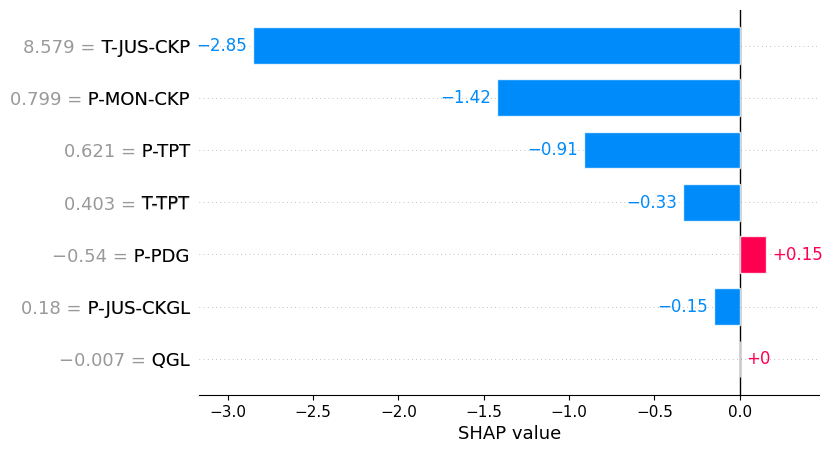

In [240]:
shap.plots.bar(shap_values_[100], show=False, max_display=12)

<Axes: xlabel='SHAP value'>

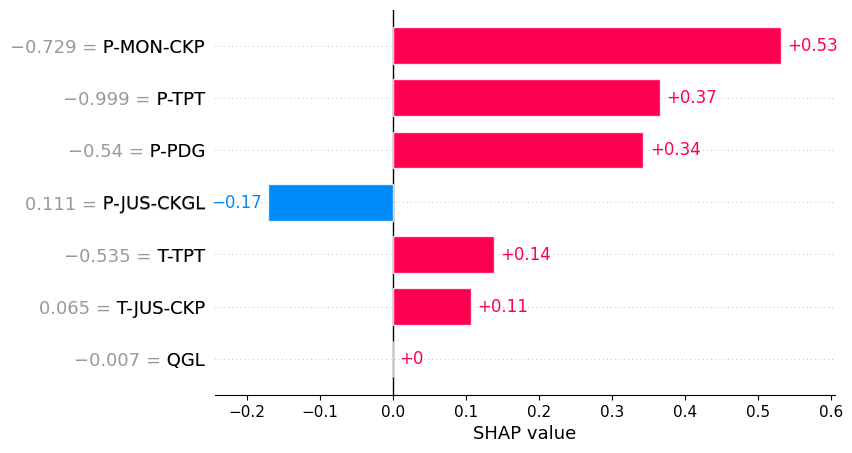

In [241]:
shap.plots.bar(shap_values_[4000], show=False, max_display=12)

### Poço 6

In [242]:
train_sample_ewma_under_control = train[(train['target'] == 0)&(train['well']=='WELL-00006')].reset_index(drop=True)
scores_train_under_control = train_sample_ewma_under_control['scores_forest'].values
# scores_train_under_control = train_sample_ewma_under_control['scores_loda'].values
sigma = np.std(scores_train_under_control)
print('sigma', sigma)
mu = np.mean(scores_train_under_control)
print('mu', mu)

train_sample_ewma_out_of_control = train[(train['target'] == 1)&(train['well']=='WELL-00006')].reset_index(drop=True)
scores_train_out_of_control = train_sample_ewma_out_of_control['scores_forest'].values
# scores_train_out_of_control = train_sample_ewma_out_of_control['scores_loda'].values
anomaly_mu = np.mean(scores_train_out_of_control)
print('anomaly_mu', anomaly_mu)

sigma 0.026861601418079428
mu -0.12487897538555812
anomaly_mu -0.058312928949638146


In [243]:
test_sample_ewma = pd.concat([train[train['well']=='WELL-00006'], test[test['well']=='WELL-00006']], axis=0)
test_sample_ewma = test_sample_ewma.reset_index(drop=True)
test_sample_ewma.shape

(2588359, 12)

EWMA Control Chart (λ=0.5, L=3)


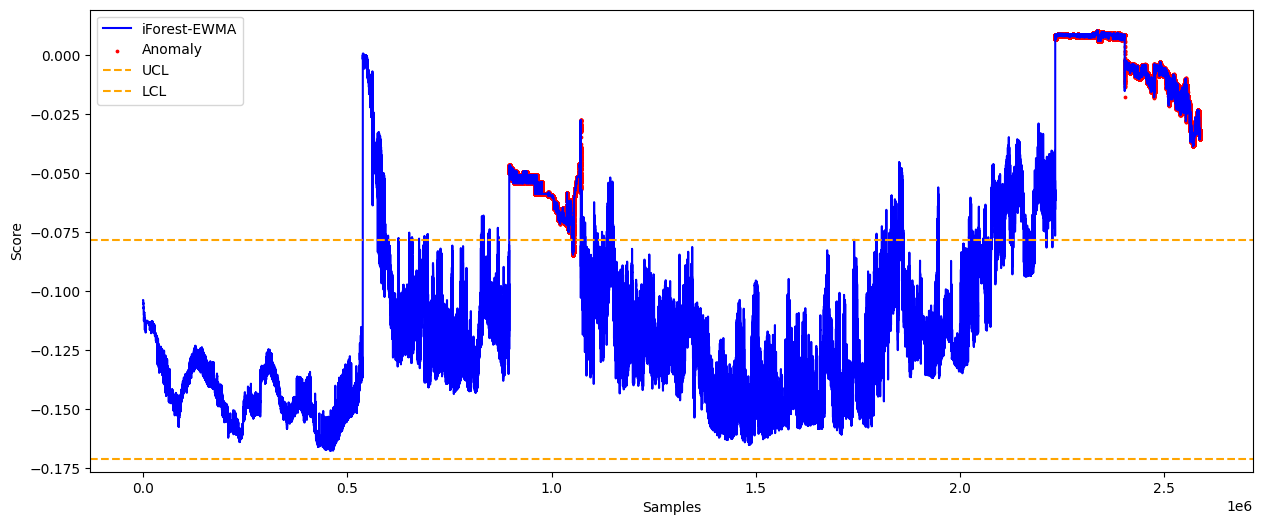

In [244]:
test_scores = test_sample_ewma['scores_forest']
# test_scores = test_sample_ewma['scores_loda']

# Definir parâmetros EWMA
lambda_ = 0.5  
L = 3 


ewma = calculate_ewma(test_scores, lambda_)

ucl, lcl = calculate_control_limits(mu, sigma, lambda_, L)


# plot_control_chart_anomaly_detection(test_sample_ewma, ewma, ucl, lcl, lambda_, L)
plot_control_chart_anomaly_detection(test_sample_ewma, test_scores, ewma, ucl, lcl, lambda_, L)

In [245]:
categories = classify_points(test_scores, ewma, ucl, lcl)


# test_sample_ewma['ucl'] = ucl 
# test_sample_ewma['lcl'] = lcl
# test_sample_ewma['ewma'] = ewma

In [246]:
test_sample_ewma['categories'] = categories 

In [247]:
pd.crosstab(test_sample_ewma.target, test_sample_ewma.categories, margins=True, normalize=True)

categories  Anomalous  Attention Needed       All
target                                           
0            0.084825          0.710429  0.795254
1            0.203448          0.001298  0.204746
All          0.288273          0.711727  1.000000

In [248]:
pd.crosstab(test_sample_ewma.target, test_sample_ewma.categories, margins=True, normalize=False)

categories  Anomalous  Attention Needed      All
target                                          
0              219558           1838845  2058403
1              526596              3360   529956
All            746154           1842205  2588359

In [249]:
Precision = 526596/(526596+219558)
Recall = 526596/(526596+3360)

print('Precision', Precision)
print('Recall', Recall)

Precision 0.7057470709799853
Recall 0.9936598510064987


In [250]:
test_sample_ewma.shape

(2588359, 13)

In [374]:
test_sample = test_sample_ewma.sample(frac=0.02, random_state=45)
test_sample_shap = test_sample[VARS]
test_sample_shap.shape

(51767, 7)

In [375]:
iforest

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG', 'P-TPT', 'T-TPT',
                                                 'P-MON-CKP', 'T-JUS-CKP',
                                                 'P-JUS-CKGL', 'QGL'])),
                ('estimator',
                 IsolationForest(contamination=0.01, max_features=0.7,
                                 n_estimators=256, random_state=42))])

In [376]:
exp = shap.TreeExplainer(iforest[2]) #Explainer
test_transform = iforest[1].transform((iforest[0].transform(test_sample[VARS])))
shap_values = exp.shap_values(test_transform)  #Calculate SHAP values
shap.initjs()

In [377]:
test_sample.shape

(51767, 13)

In [378]:
test_sample2 = test_sample.reset_index(drop=True)
test_sample2[(test_sample2['target']==0)&(test_sample2['iForest']==0)&(test_sample2['scores_forest']<-0.16)].tail(20)

P-PDG       P-TPT     T-TPT  P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  QGL  \
50734    0.0  18074310.0  118.8640  2474359.0   80.26715   -497671.7  0.0   
50756    0.0  18074310.0  118.8640  2473518.0   80.26302   -497671.7  0.0   
50817    0.0  18233910.0  118.8052  2485352.0   80.24683   -497671.7  0.0   
50825    0.0  18074310.0  118.8640  2464763.0   80.26081   -497671.7  0.0   
50885    0.0  18074310.0  118.8640  2474467.0   80.26374   -497671.7  0.0   
50904    0.0  18074310.0  118.8640  2474364.0   80.26366   -497671.7  0.0   
50984    0.0  18074310.0  118.8640  2477372.0   80.26597   -497671.7  0.0   
50992    0.0  18074310.0  118.8640  2468949.0   80.26154   -497671.7  0.0   
51133    0.0  18074310.0  118.8640  2476595.0   80.26537   -497671.7  0.0   
51146    0.0  18074310.0  118.8640  2473670.0   80.26724   -497671.7  0.0   
51212    0.0  18074310.0  118.8671  2471685.0   80.26201   -497671.7  0.0   
51254    0.0  18074310.0  118.8640  2465697.0   80.26097   -497671.7  0.0   
51308    0.0  18074310.0  118.8640  2475350.0   80.26442   -497671.7  0.0   
51396    0.0  18233910.0  118.7905  2483484.0   80.22363   -497671.7  0.0   
51417    0.0  18074310.0  118.8640  2473477.0   80.26299   -497671.7  0.0   
51427    0.0  18074310.0  118.8640  2463865.0   80.25934   -497671.7  0.0   
51472    0.0  18074310.0  118.8681  2470155.0   80.26174   -497671.7  0.0   
51536    0.0  18074310.0  118.8640  2476164.0   80.26505   -497671.7  0.0   
51568    0.0  18074310.0  118.8640  2475961.0   80.26489   -497671.7  0.0   
51588    0.0  18074310.0  118.8640  2473553.0   80.26304   -497671.7  0.0   

                timestamp        well  target  iForest  scores_forest  \
50734 2017-02-23 16:15:47  WELL-00006       0        0      -0.165326   
50756 2017-02-23 22:52:27  WELL-00006       0        0      -0.166862   
50817 2017-02-09 16:53:36  WELL-00006       0        0      -0.162744   
50825 2017-02-24 04:55:27  WELL-00006       0        0      -0.162667   
50885 2017-02-23 21:42:33  WELL-00006       0        0      -0.166835   
50904 2017-02-23 21:50:09  WELL-00006       0        0      -0.166835   
50984 2017-02-23 18:08:38  WELL-00006       0        0      -0.165065   
50992 2017-02-24 02:36:41  WELL-00006       0        0      -0.165499   
51133 2017-02-23 19:05:49  WELL-00006       0        0      -0.165720   
51146 2017-02-23 16:06:58  WELL-00006       0        0      -0.165197   
51212 2017-02-24 01:06:01  WELL-00006       0        0      -0.166006   
51254 2017-02-24 04:24:28  WELL-00006       0        0      -0.163271   
51308 2017-02-23 20:37:32  WELL-00006       0        0      -0.167301   
51396 2017-02-09 15:51:40  WELL-00006       0        0      -0.163196   
51417 2017-02-23 22:55:30  WELL-00006       0        0      -0.166862   
51427 2017-02-23 14:01:30  WELL-00006       0        0      -0.162770   
51472 2017-02-24 01:56:44  WELL-00006       0        0      -0.165231   
51536 2017-02-23 19:37:34  WELL-00006       0        0      -0.166520   
51568 2017-02-23 19:52:32  WELL-00006       0        0      -0.166512   
51588 2017-02-23 22:49:53  WELL-00006       0        0      -0.166862   

             categories  
50734  Attention Needed  
50756  Attention Needed  
50817  Attention Needed  
50825  Attention Needed  
50885  Attention Needed  
50904  Attention Needed  
50984  Attention Needed  
50992  Attention Needed  
51133  Attention Needed  
51146  Attention Needed  
51212  Attention Needed  
51254  Attention Needed  
51308  Attention Needed  
51396  Attention Needed  
51417  Attention Needed  
51427  Attention Needed  
51472  Attention Needed  
51536  Attention Needed  
51568  Attention Needed  
51588  Attention Needed

In [384]:
j = 51308#12938#2000
test_sample2.iloc[j,:]

P-PDG                            0.0
P-TPT                     18074310.0
T-TPT                        118.864
P-MON-CKP                  2475350.0
T-JUS-CKP                   80.26442
P-JUS-CKGL                 -497671.7
QGL                              0.0
timestamp        2017-02-23 20:37:32
well                      WELL-00006
target                             0
iForest                            0
scores_forest              -0.167301
categories          Attention Needed
Name: 51308, dtype: object

In [385]:
shap.force_plot(exp.expected_value, shap_values[j],features =test_transform.iloc[j,:] ,feature_names =test_transform.columns)

In [390]:
test_sample2 = test_sample.reset_index(drop=True)
test_sample2[(test_sample2['target']==1)&(test_sample2['iForest']==1)].head(20)

P-PDG       P-TPT     T-TPT   P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  \
1   -1.180116e+42  20643960.0  118.2305  10597560.0   70.59538   4164540.0   
26  -1.180116e+42  20647810.0  118.2299  10616340.0   70.49648   4161142.0   
32  -1.180116e+42  20647810.0  118.2390  10414430.0   70.67243   4117874.0   
44  -1.180116e+42  20787460.0  117.9249  10073660.0   70.94356   4102964.0   
131 -1.180116e+42  20787460.0  117.9265  10090840.0   70.91508   4073484.0   
132 -1.180116e+42  20787460.0  117.8985  10093440.0   70.89339   4087966.0   
133 -1.180116e+42  20647810.0  118.1826   9992929.0   71.23925   4108035.0   
143 -1.180116e+42  20647810.0  118.2181  10582030.0   70.61826   4155570.0   
146 -1.180116e+42  20787460.0  117.8549  10105820.0   70.87713   4051321.0   
165 -1.180116e+42  20807910.0  117.8366  10130610.0   70.83772   4040121.0   
181 -1.180116e+42  20662440.0  118.1999  10671370.0   70.38745   4179285.0   
202 -1.180116e+42  20787460.0  117.9265  10106350.0   70.96767   4065868.0   
215 -1.180116e+42  20707660.0  118.0599  10028420.0   70.91166   4106719.0   
221 -1.180116e+42  20787460.0  117.9256  10100670.0   71.02438   4061092.0   
229 -1.180116e+42  20667760.0  118.2390  10681860.0   70.59409   4185007.0   
240 -1.180116e+42  20667760.0  118.2390  10516350.0   70.67673   4128127.0   
250 -1.180116e+42  20647810.0  118.2142  10626930.0   70.37880   4173949.0   
323 -1.180116e+42  20825050.0  117.8842  10127400.0   70.89851   4042318.0   
354 -1.180116e+42  20667760.0  118.2390  10493420.0   70.59148   4126146.0   
361 -1.180116e+42  20787460.0  117.9265  10070860.0   70.86501   4091238.0   

     QGL           timestamp        well  target  iForest  scores_forest  \
1    0.0 2018-06-18 22:04:40  WELL-00006       1        1       0.008590   
26   0.0 2018-06-18 21:35:09  WELL-00006       1        1       0.008590   
32   0.0 2018-06-18 15:19:20  WELL-00006       1        1       0.008590   
44   0.0 2018-06-18 06:57:59  WELL-00006       1        1       0.007987   
131  0.0 2018-06-18 02:59:00  WELL-00006       1        1       0.008858   
132  0.0 2018-06-18 04:55:20  WELL-00006       1        1       0.008361   
133  0.0 2018-06-18 10:25:53  WELL-00006       1        1       0.007875   
143  0.0 2018-06-18 20:46:45  WELL-00006       1        1       0.008590   
146  0.0 2018-06-18 00:00:58  WELL-00006       1        1       0.008019   
165  0.0 2018-06-17 18:14:59  WELL-00006       1        1       0.008136   
181  0.0 2018-06-19 00:44:21  WELL-00006       1        1       0.006830   
202  0.0 2018-06-18 01:57:49  WELL-00006       1        1       0.008858   
215  0.0 2018-06-18 09:31:57  WELL-00006       1        1       0.010154   
221  0.0 2018-06-18 01:19:27  WELL-00006       1        1       0.008858   
229  0.0 2018-06-19 01:52:26  WELL-00006       1        1       0.008590   
240  0.0 2018-06-18 16:48:23  WELL-00006       1        1       0.008590   
250  0.0 2018-06-18 23:40:51  WELL-00006       1        1       0.006830   
323  0.0 2018-06-17 21:15:08  WELL-00006       1        1       0.008716   
354  0.0 2018-06-18 16:31:11  WELL-00006       1        1       0.008590   
361  0.0 2018-06-18 05:21:37  WELL-00006       1        1       0.008336   

    categories  
1    Anomalous  
26   Anomalous  
32   Anomalous  
44   Anomalous  
131  Anomalous  
132  Anomalous  
133  Anomalous  
143  Anomalous  
146  Anomalous  
165  Anomalous  
181  Anomalous  
202  Anomalous  
215  Anomalous  
221  Anomalous  
229  Anomalous  
240  Anomalous  
250  Anomalous  
323  Anomalous  
354  Anomalous  
361  Anomalous

In [393]:
j = 1
test_sample.iloc[j,:]

P-PDG           -1180115999999999990862276961833067531468800.0
P-TPT                                               20643960.0
T-TPT                                                 118.2305
P-MON-CKP                                           10597560.0
T-JUS-CKP                                             70.59538
P-JUS-CKGL                                           4164540.0
QGL                                                        0.0
timestamp                                  2018-06-18 22:04:40
well                                                WELL-00006
target                                                       1
iForest                                                      1
scores_forest                                          0.00859
categories                                           Anomalous
Name: 2386762, dtype: object

In [394]:
shap.force_plot(exp.expected_value, shap_values[j],features =test_transform.iloc[j,:] ,feature_names =test_transform.columns)

In [395]:
shap_values_ = exp(test_transform)

<Axes: xlabel='SHAP value'>

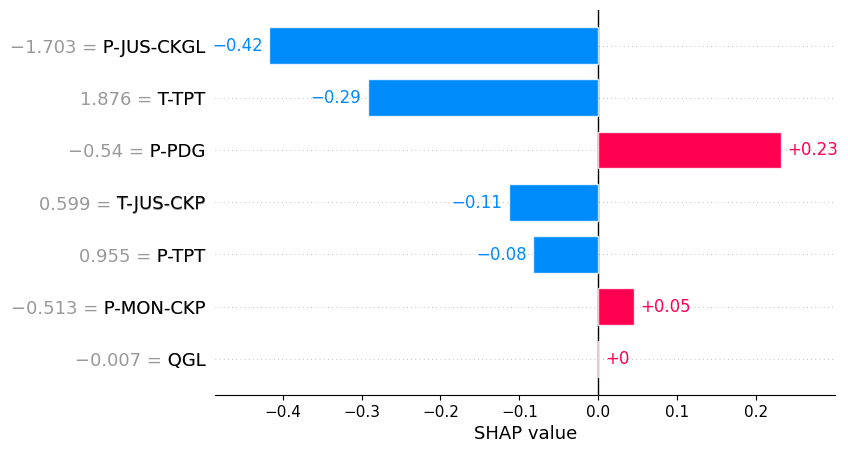

In [398]:
shap.plots.bar(shap_values_[25882], show=False, max_display=12)

<Axes: xlabel='SHAP value'>

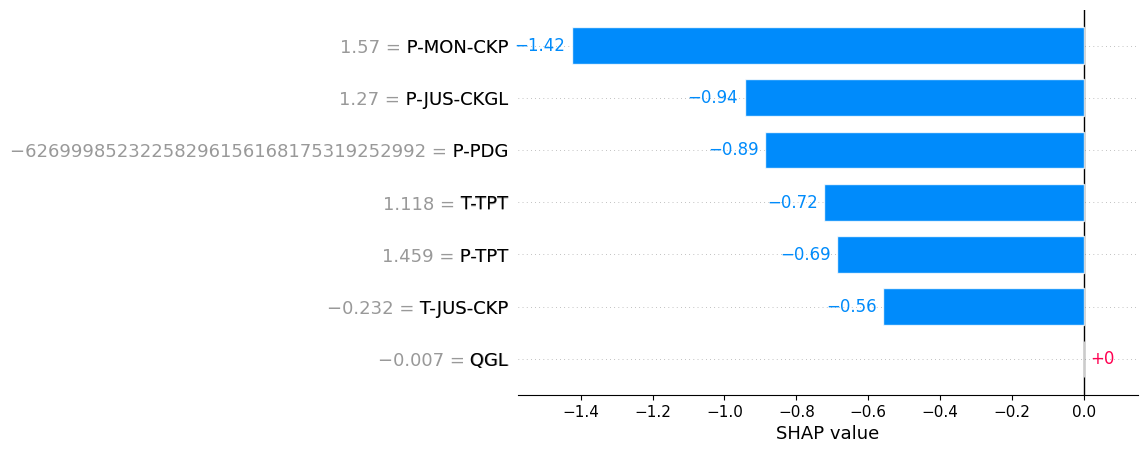

In [399]:
shap.plots.bar(shap_values_[1], show=False, max_display=12)

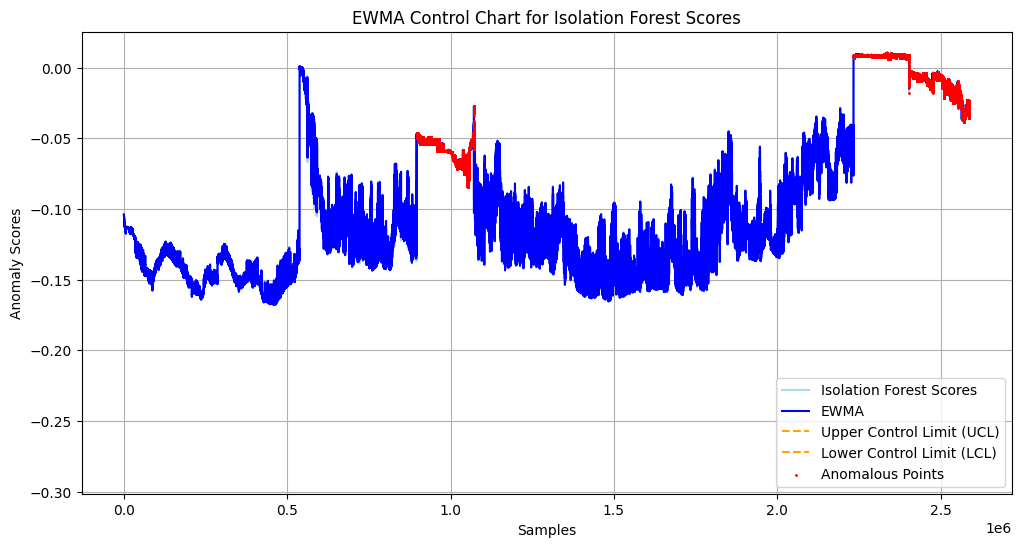

In [68]:
# Classificar os pontos com base nos limites de controle
categories = classify_points(test_scores, ewma, ucl, lcl)

anomaous_target = test_sample_ewma.target.tolist()
# anomalous_indices = [i for i in range(len(categories)) if categories[i] == 'Anomalous']
anomalous_indices = [i for i in range(len(anomaous_target)) if anomaous_target[i] == 1]

# Plotar os gráficos de controle EWMA para os escores do Isolation Forest
plt.figure(figsize=(12, 6))
plt.plot(test_scores, label='Isolation Forest Scores', color='lightblue',  zorder=1)
plt.plot(ewma, label='EWMA', color='blue',  zorder=2)
plt.plot(ucl, 'r--', label='Upper Control Limit (UCL)', color='orange',  zorder=3)
plt.plot(lcl, 'r--', label='Lower Control Limit (LCL)', color='orange',  zorder=3)
# plt.scatter(anomalous_indices, [ewma[i] for i in anomalous_indices], color='red', label='Anomalous Points')
# plt.scatter(anomalous_indices, [test_scores[i] for i in anomalous_indices], color='red', label='Anomalous Points')
plt.scatter(anomalous_indices, [test_scores[i] for i in anomalous_indices], color='red', label='Anomalous Points', s=1, zorder=4)
plt.xlabel('Samples')
plt.ylabel('Anomaly Scores')
plt.title('EWMA Control Chart for Isolation Forest Scores')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=list(range(len(escores))),
#     y=escores,
#     mode='lines',
#     name='Isolation Forest Scores',
#     line=dict(color='lightblue'),
#     zorder=1
# ))

# fig.add_trace(go.Scatter(
#     x=list(range(len(ewma))),
#     y=ewma,
#     mode='lines',
#     name='EWMA',
#     line=dict(color='blue'),
#     zorder=2
# ))

# fig.add_trace(go.Scatter(
#     x=list(range(len(ucl))),
#     y=ucl,
#     mode='lines',
#     name='Upper Control Limit (UCL)',
#     line=dict(color='gray', dash='dash'),
#     zorder=3
# ))

# fig.add_trace(go.Scatter(
#     x=list(range(len(lcl))),
#     y=lcl,
#     mode='lines',
#     name='Lower Control Limit (LCL)',
#     line=dict(color='gray', dash='dash'),
#     zorder=3
# ))

# fig.add_trace(go.Scatter(
#     x=anomalous_indices,
#     y=[escores[i] for i in anomalous_indices],
#     mode='markers',
#     name='Anomalous Points',
#     marker=dict(color='red', size=6),
#     zorder=4
# ))

# fig.update_layout(
#     # title='EWMA Control Chart for Isolation Forest Scores',
#     xaxis_title='Samples',
#     yaxis_title='Anomaly Scores',
#     legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
# )

# fig.show()

In [75]:
test_sample_ewma.shape

(4000, 12)

In [76]:
exp = shap.TreeExplainer(iforest[2]) #Explainer
test_transform = iforest[1].transform((iforest[0].transform(test_sample_ewma[VARS])))
shap_values = exp.shap_values(test_transform)  #Calculate SHAP values
shap.initjs()

In [56]:
# explainer = shap.TreeExplainer(iforest)
# shap_values = explainer.shap_values(test_sample_ewma[VARS])

In [66]:
# shap.initjs()
# shap.force_plot(exp.expected_value, shap_values[:,:], test_sample_ewma[VARS].iloc[:,:])

In [77]:
shap.initjs()
shap.force_plot(exp.expected_value, shap_values[:,:], test_transform[VARS].iloc[:,:])

In [42]:
test_sample_ewma['ucl'] = ucl 
test_sample_ewma['lcl'] = lcl
test_sample_ewma['ewma'] = ewma

In [43]:
test_sample_ewma['categories'] = categories

In [44]:
pd.crosstab(test_sample_ewma.target, test_sample_ewma.categories)

categories  Anomalous  Attention Needed
target                                 
0                   0            162890
1                   6             95940

In [45]:
pd.crosstab(test_sample_ewma.target, test_sample_ewma.categories, normalize=True)

categories  Anomalous  Attention Needed
target                                 
0            0.000000          0.629317
1            0.000023          0.370659

In [37]:
# metrics(test_sample_ewma.target, test_sample_ewma.categories)

In [46]:
test_sample_ewma[(test_sample_ewma['target']==1)&(test_sample_ewma['scores_forest']>=0)&(test_sample_ewma['categories']=='Anomalous')]

P-PDG       P-TPT     T-TPT   P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  \
162890 -1.180116e+42  20813670.0  117.8476  10136810.0   70.83952   4040100.0   
162891 -1.180116e+42  20813610.0  117.8475  10136690.0   70.83950   4040100.0   
162892 -1.180116e+42  20813560.0  117.8474  10136560.0   70.83949   4040100.0   
162893 -1.180116e+42  20813500.0  117.8473  10136440.0   70.83947   4040100.0   
162894 -1.180116e+42  20813450.0  117.8472  10136320.0   70.83945   4040101.0   
162895 -1.180116e+42  20813390.0  117.8471  10136200.0   70.83943   4040101.0   

        QGL           timestamp        well  target  iForest  scores_forest  \
162890  0.0 2018-06-17 18:13:15  WELL-00006       1        1       0.061114   
162891  0.0 2018-06-17 18:13:16  WELL-00006       1        1       0.061114   
162892  0.0 2018-06-17 18:13:17  WELL-00006       1        1       0.061114   
162893  0.0 2018-06-17 18:13:18  WELL-00006       1        1       0.061114   
162894  0.0 2018-06-17 18:13:19  WELL-00006       1        1       0.061114   
162895  0.0 2018-06-17 18:13:20  WELL-00006       1        1       0.061114   

             ucl       lcl      ewma categories  
162890  0.046027  0.003131  0.024579  Anomalous  
162891  0.049681  0.006785  0.028233  Anomalous  
162892  0.052969  0.010073  0.031521  Anomalous  
162893  0.055928  0.013032  0.034480  Anomalous  
162894  0.058592  0.015696  0.037144  Anomalous  
162895  0.060989  0.018093  0.039541  Anomalous

In [47]:
test_sample_ewma[(test_sample_ewma['target']==1)&(test_sample_ewma['scores_forest']>=0)].shape

(95946, 16)

In [48]:
test_sample_ewma[(test_sample_ewma['target']==1)&(test_sample_ewma['scores_forest']<0)].shape

(0, 16)

In [49]:
test_sample_ewma[test_sample_ewma['target']==1].head(30)

P-PDG       P-TPT     T-TPT   P-MON-CKP  T-JUS-CKP  P-JUS-CKGL  \
162890 -1.180116e+42  20813670.0  117.8476  10136810.0   70.83952   4040100.0   
162891 -1.180116e+42  20813610.0  117.8475  10136690.0   70.83950   4040100.0   
162892 -1.180116e+42  20813560.0  117.8474  10136560.0   70.83949   4040100.0   
162893 -1.180116e+42  20813500.0  117.8473  10136440.0   70.83947   4040100.0   
162894 -1.180116e+42  20813450.0  117.8472  10136320.0   70.83945   4040101.0   
162895 -1.180116e+42  20813390.0  117.8471  10136200.0   70.83943   4040101.0   
162896 -1.180116e+42  20813340.0  117.8470  10136080.0   70.83942   4040101.0   
162897 -1.180116e+42  20813280.0  117.8469  10135960.0   70.83940   4040102.0   
162898 -1.180116e+42  20813220.0  117.8468  10135840.0   70.83939   4040102.0   
162899 -1.180116e+42  20813170.0  117.8467  10135720.0   70.83936   4040102.0   
162900 -1.180116e+42  20813110.0  117.8466  10135600.0   70.83935   4040102.0   
162901 -1.180116e+42  20813060.0  117.8465  10135480.0   70.83933   4040102.0   
162902 -1.180116e+42  20813000.0  117.8464  10135360.0   70.83931   4040102.0   
162903 -1.180116e+42  20812950.0  117.8462  10135240.0   70.83929   4040103.0   
162904 -1.180116e+42  20812890.0  117.8461  10135120.0   70.83928   4040103.0   
162905 -1.180116e+42  20812840.0  117.8460  10135000.0   70.83926   4040103.0   
162906 -1.180116e+42  20812780.0  117.8459  10134880.0   70.83924   4040103.0   
162907 -1.180116e+42  20812730.0  117.8458  10134760.0   70.83923   4040104.0   
162908 -1.180116e+42  20812670.0  117.8457  10134640.0   70.83921   4040104.0   
162909 -1.180116e+42  20812620.0  117.8456  10134510.0   70.83920   4040104.0   
162910 -1.180116e+42  20812560.0  117.8455  10134390.0   70.83917   4040104.0   
162911 -1.180116e+42  20812500.0  117.8454  10134270.0   70.83916   4040104.0   
162912 -1.180116e+42  20812450.0  117.8453  10134150.0   70.83914   4040105.0   
162913 -1.180116e+42  20812390.0  117.8452  10134030.0   70.83913   4040105.0   
162914 -1.180116e+42  20812340.0  117.8451  10133910.0   70.83910   4040105.0   
162915 -1.180116e+42  20812280.0  117.8450  10133790.0   70.83909   4040105.0   
162916 -1.180116e+42  20812230.0  117.8449  10133670.0   70.83907   4040105.0   
162917 -1.180116e+42  20812170.0  117.8448  10133550.0   70.83905   4040105.0   
162918 -1.180116e+42  20812120.0  117.8447  10133430.0   70.83904   4040106.0   
162919 -1.180116e+42  20812060.0  117.8446  10133310.0   70.83902   4040106.0   

        QGL           timestamp        well  target  iForest  scores_forest  \
162890  0.0 2018-06-17 18:13:15  WELL-00006       1        1       0.061114   
162891  0.0 2018-06-17 18:13:16  WELL-00006       1        1       0.061114   
162892  0.0 2018-06-17 18:13:17  WELL-00006       1        1       0.061114   
162893  0.0 2018-06-17 18:13:18  WELL-00006       1        1       0.061114   
162894  0.0 2018-06-17 18:13:19  WELL-00006       1        1       0.061114   
162895  0.0 2018-06-17 18:13:20  WELL-00006       1        1       0.061114   
162896  0.0 2018-06-17 18:13:21  WELL-00006       1        1       0.061114   
162897  0.0 2018-06-17 18:13:22  WELL-00006       1        1       0.061114   
162898  0.0 2018-06-17 18:13:23  WELL-00006       1        1       0.061114   
162899  0.0 2018-06-17 18:13:24  WELL-00006       1        1       0.061114   
162900  0.0 2018-06-17 18:13:25  WELL-00006       1        1       0.061114   
162901  0.0 2018-06-17 18:13:26  WELL-00006       1        1       0.061114   
162902  0.0 2018-06-17 18:13:27  WELL-00006       1        1       0.061114   
162903  0.0 2018-06-17 18:13:28  WELL-00006       1        1       0.061114   
162904  0.0 2018-06-17 18:13:29  WELL-00006       1        1       0.061114   
162905  0.0 2018-06-17 18:13:30  WELL-00006       1        1       0.061114   
162906  0.0 2018-06-17 18:13:31  WELL-00006       1        1       0.061114   
162907  0.0 2018-06-17 18:13:32  WELL-00006       1        1       0.061114   
16

In [42]:
test_sample_ewma.shape

(444, 16)

In [43]:
test_sample_ewma_attention = test_sample_ewma[test_sample_ewma['categories']=='Attention Needed']
test_sample_ewma_attention = test_sample_ewma_attention[VARS]

In [44]:
explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(test_sample_ewma_attention)

In [45]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:], test_sample_ewma_attention[VARS].iloc[:,:])

In [46]:
test_sample_ewma_attention = test_sample_ewma[test_sample_ewma['categories']=='Normal']
test_sample_ewma_attention = test_sample_ewma_attention[VARS]

In [47]:
explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(test_sample_ewma_attention)

In [48]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:], test_sample_ewma_attention[VARS].iloc[:,:])

In [49]:
test_sample_ewma_anomalous = test_sample_ewma[test_sample_ewma['categories']=='Anomalous']
test_sample_ewma_anomalous = test_sample_ewma_anomalous[VARS]

In [50]:
explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(test_sample_ewma_anomalous)

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:,:], test_sample_ewma_attention[VARS].iloc[:,:])

In [ ]:
# for i in anomalous_indices[:5]:  
#     shap.force_plot(explainer.expected_value, shap_values[i], test_sample_ewma[VARS].iloc[i], matplotlib=True)

# # Exibir gráfico de resumo SHAP para todas as anomalias
# shap.summary_plot(shap_values, test_sample_ewma[VARS])

In [ ]:
test_sample_ewma.head()

### EWMA para valores SHAP das variáveis 

In [52]:
# Função para calcular EWMA
def calculate_ewma(values, lambda_):
    ewma_values = np.zeros_like(values)
    ewma_values[0] = values[0]
    for i in range(1, len(values)):
        ewma_values[i] = lambda_ * values[i] + (1 - lambda_) * ewma_values[i-1]
    return ewma_values

# Função para calcular UCL e LCL
def calculate_control_limits(ewma_values, std_ewma, L=3):
    mean_ewma = np.mean(ewma_values)
    # std_ewma = np.std(ewma_values)
    ucl = mean_ewma + L * std_ewma
    lcl = mean_ewma - L * std_ewma
    return ucl, lcl

    # Calcular o desvio padrão dos escores no conjunto de treino sem anomalias
train_sample_ewma = train[train['target'] == 0].sample(frac=0.01, random_state=51).reset_index(drop=True)
# escores_train = -train_sample_ewma['scores_forest']
# Calcular valores SHAP
explainer = shap.TreeExplainer(iforest)
shap_values_train = explainer.shap_values(train_sample_ewma[VARS])


test_sample_ewma = test.sample(frac=0.0002, random_state=52).reset_index(drop=True)
# escores = -test_sample_ewma['scores_forest']


# Calcular valores SHAP
explainer = shap.TreeExplainer(iforest)
shap_values = explainer.shap_values(test_sample_ewma[VARS])

In [53]:
# Definir parâmetros EWMA
lambda_ = 0.2  # Fator de suavização, geralmente entre 0.1 e 0.3
L = 3  # Multiplicador para limites de controle

# Calcular EWMA para cada variável preditora
shap_ewma = np.apply_along_axis(calculate_ewma, 0, shap_values, lambda_)

anomaous_target = test_sample_ewma.target.tolist()
# anomalous_indices = [i for i in range(len(categories)) if categories[i] == 'Anomalous']
anomalous_indices = [i for i in range(len(anomaous_target)) if anomaous_target[i] == 1]

# # Visualizar os resultados com UCL e LCL
# for i in range(shap_ewma.shape[1]):
#     plt.figure(figsize=(12, 6))
#     plt.plot(shap_values[:, i], label=f'SHAP values for feature {VARS[i]}', color='lightblue', zorder=1)
    
#     plt.plot(shap_ewma[:, i], label=f'EWMA of SHAP values for feature {VARS[i]}', color='orange', zorder=2)


#     shap_ewma_train = np.apply_along_axis(calculate_ewma, 0, shap_values_train[:, i], lambda_)
#     sigma_i = np.std(shap_ewma_train)
    
#     # Calcular UCL e LCL
#     # ucl, lcl = calculate_control_limits(shap_ewma[:, i], sigma_i, L=3)
#     ucl = shap_ewma[:, i] + L * sigma_i * np.sqrt(lambda_ / (2 - lambda_))
#     lcl = shap_ewma[:, i] - L * sigma_i * np.sqrt(lambda_ / (2 - lambda_))

#     plt.plot(ucl, 'r--', label='Upper Control Limit (UCL)', color='gray',  zorder=3)
#     plt.plot(lcl, 'r--', label='Lower Control Limit (LCL)', color='gray',  zorder=3)
    
#     plt.scatter(anomalous_indices, [escores[i] for i in anomalous_indices], color='red', label='Anomalous Points', s=10, zorder=4)
#     plt.xlabel('Samples')
#     plt.ylabel('SHAP values')
#     plt.title(f'EWMA of SHAP values for feature {VARS[i]}')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

In [54]:
# Loop para criar gráficos para cada característica
for i in range(shap_ewma.shape[1]):
    fig = go.Figure()

    # Adicionar SHAP values
    fig.add_trace(go.Scatter(
        x=list(range(len(shap_values))),
        y=shap_values[:, i],
        mode='lines',
        name=f'SHAP values for feature {VARS[i]}',
        line=dict(color='lightblue'),
        zorder=1
    ))

    # Adicionar EWMA dos SHAP values
    fig.add_trace(go.Scatter(
        x=list(range(len(shap_ewma))),
        y=shap_ewma[:, i],
        mode='lines',
        name=f'EWMA of SHAP values for feature {VARS[i]}',
        line=dict(color='orange'),
        zorder=2
    ))

    # Calcular UCL e LCL
    shap_ewma_train = np.apply_along_axis(calculate_ewma, 0, shap_values_train[:, i], lambda_)
    sigma_i = np.std(shap_ewma_train)
    ucl = shap_ewma[:, i] + L * sigma_i * np.sqrt(lambda_ / (2 - lambda_))
    lcl = shap_ewma[:, i] - L * sigma_i * np.sqrt(lambda_ / (2 - lambda_))


    fig.add_trace(go.Scatter(
        x=list(range(len(ucl))),
        y=ucl,
        mode='lines',
        name='Upper Control Limit (UCL)',
        line=dict(color='gray', dash='dash'),
        zorder=3
    ))

    fig.add_trace(go.Scatter(
        x=list(range(len(lcl))),
        y=lcl,
        mode='lines',
        name='Lower Control Limit (LCL)',
        line=dict(color='gray', dash='dash'),
        zorder=3
    ))

    fig.add_trace(go.Scatter(
        x=anomalous_indices,
        y=[shap_values[j, i] for j in anomalous_indices],
        mode='markers',
        name='Anomalous Points',
        marker=dict(color='red', size=6),  
        zorder=4
    ))

    fig.update_layout(
        title=f'EWMA of SHAP values for feature {VARS[i]}',
        xaxis_title='Samples',
        yaxis_title='SHAP values',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
    )

    fig.show()